[View in Colaboratory](https://colab.research.google.com/github/kywch/deep-learning-practice/blob/master/fastai_lesson7.ipynb)

## References

For tips related colab, see https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

For setting up colab to use pytorch and fastai, see https://towardsdatascience.com/fast-ai-lesson-1-on-google-colab-free-gpu-d2af89f53604

The below codes are taken from http://course.fast.ai/lessons/lesson7.html, http://forums.fast.ai/t/wiki-lesson-7/9405 

# Setting up the playground


## To make sure if notebook is running on GPU background

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!/opt/bin/nvidia-smi

Thu Apr 26 22:54:29 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    54W / 149W |  10875MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Installing pytorch

In [3]:
import sys
print (sys.version)

3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]


In [8]:
#!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip install torchvision
#!pip install http://download.pytorch.org/whl/cu75/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl  && pip install torchvision
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


### Workaround for an issue with PIL
For *"AttributeError: module ‘PIL.Image’ has no attribute ‘register_extensions"*, refer this [link](http://forums.fast.ai/t/attributeerror-module-pil-image-has-no-attribute-register-extensions/10689/3) for information related to this issue and workaround.

In [10]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


## Installing fastai

In [45]:
!pip install https://github.com/fastai/fastai/archive/master.zip

ERROR: unknown command "upgrade"


In [0]:
import fastai


# Download the dataset - CIFAR 10

In [0]:
from fastai import io
import os
import tarfile
import shutil
def download_cifar10(data_path):
    # (AS) TODO: put this into the fastai library
    def untar_file(file_path, save_path):
        if file_path.endswith('.tar.gz') or file_path.endswith('.tgz'):
            obj = tarfile.open(file_path)
            obj.extractall(save_path)
            obj.close()
            os.remove(file_path)

    cifar_url = 'http://files.fast.ai/data/cifar10.tgz' # faster download
    # cifar_url = 'http://pjreddie.com/media/files/cifar.tgz'
    io.get_data(cifar_url, data_path+'/cifar10.tgz')
    untar_file(data_path+'/cifar10.tgz', data_path)
    # Loader expects train and test folders to be outside of cifar10 folder
    shutil.move(data_path+'/cifar10/train', data_path)
    shutil.move(data_path+'/cifar10/test', data_path)


In [20]:
data_dir = 'cifar10_data'
!mkdir {data_dir}
download_cifar10(data_dir)

mkdir: cannot create directory ‘cifar10_data’: File exists


In [21]:
# make sure the data is here
!ls {data_dir}/train

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [0]:
# just run these in every notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *

def get_data(img_size, batch_size):
    tfms = tfms_from_stats(stats, img_size, aug_tfms=[RandomFlip()], pad=img_size//8)
    return ImageClassifierData.from_paths(data_dir, val_name='test', tfms=tfms, bs=batch_size)

In [0]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
batch_size = 256

## Looking at the dataset

In [25]:
files = !ls {data_dir}/train/airplane  | head
files

['10008_airplane.png',
 '10010_airplane.png',
 '10020_airplane.png',
 '10024_airplane.png',
 '10031_airplane.png',
 '10043_airplane.png',
 '10050_airplane.png',
 '10061_airplane.png',
 '10064_airplane.png',
 '10115_airplane.png']

In [33]:
data = get_data(32, 4)
[data, len(data.trn_dl), len(data.val_dl)]

[<fastai.dataset.ImageClassifierData at 0x7f73d4c009e8>, 12500, 2500]

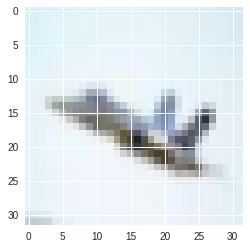

In [27]:
img = plt.imread(f'{data_dir}/train/airplane/{files[0]}')
plt.imshow(img);

In [35]:
image_size = 32;
img.shape

(32, 32, 3)

# ResNets from scratch

## Fully connected model

In [46]:
data = get_data(image_size, batch_size)
[data, len(data.trn_dl), len(data.val_dl)]

[<fastai.dataset.ImageClassifierData at 0x7f73d3f1ce48>, 196, 40]

In [0]:
learn_rate = 1e-2

In [0]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [47]:
# input layer: 32 x 32 px x RGB
# hidden layer of 40 fully-connected units
# output layer: 10 units for classifying 10 classes

learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)


AttributeError: ignored

In [0]:
ConvLearner.